# Code to produce figure 5b

### Zoïs Moitier (2021)
            
_Karlsruhe Institute of Technology, Germany_

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm

import Analytic
import BIE
import Plot

%matplotlib inline

## Internal plotting functions

In [2]:
def calc_err(result, u_ana, u_max):
    return np.abs(result[0] - u_ana).max() / u_max

In [3]:
def plot_err(α, k, M, N_vec, ε_vec, type_solver, type_inc, m):
    if type_solver.startswith("pqr"):
        solver = lambda E, trace, N, ε: BIE.helmholtz_pqr(E, k, trace, N)

    if type_solver.startswith("mpqr"):
        solver = lambda E, trace, N, ε: BIE.helmholtz_mpqr(E, k, trace, N, ε)

    if type_solver.startswith("qpax"):
        solver = lambda E, trace, N, ε: BIE.helmholtz_qpax(ε, k, trace, N)

    err = np.empty((nb_ε, nb_N))

    for i, ε in enumerate(ε_vec):
        E = BIE.ellipse(ε)
        c, ξ0 = Analytic.ellipse_param(1, ε)

        if type_inc.startswith("ful"):
            in_field = Analytic.field_plane_wave(α, k, c, m)

        if type_inc.startswith("eve"):
            in_field = Analytic.create_field(
                c, k, [[(m, 1)], [], [], []], [[], [], [], []]
            )

        if type_inc.startswith("odd"):
            in_field = Analytic.create_field(
                c, k, [[], [], [], []], [[(m, 1)], [], [], []]
            )

        if type_solver.startswith("qpax"):
            trace = Analytic.expansion_trace(in_field)
        else:

            def trace(x, y):
                ξ, η = Analytic.to_elliptic(c, x, y)
                return Analytic.eval_field(in_field, ξ, η)

        sc_field = Analytic.solve_field(in_field, ξ0, 1)

        for j, N in enumerate(N_vec):
            θ, _ = BIE.grid(N)
            x, y = ε * np.cos(θ), np.sin(θ)
            ξ, η = Analytic.to_elliptic(c, x, y)
            u_ana = Analytic.eval_field(sc_field, ξ, η) + Analytic.eval_field(
                in_field, ξ, η
            )
            u_max = np.abs(u_ana).max()

            err[i, j] = calc_err(solver(E, trace, N, ε), u_ana, u_max)

    fig_size = [1.25 * e for e in [6.4, 4.8]]
    fig, ax = plt.subplots(figsize=fig_size, constrained_layout=True)

    log_norm_err = LogNorm(err.min(), err.max())
    sns.heatmap(
        err,
        ax=ax,
        cmap="YlGnBu_r",
        norm=log_norm_err,
        xticklabels=N_vec,
        yticklabels=ε_str,
    )
    ax.set_xlabel(r"$N$", fontsize=15)
    ax.set_ylabel(r"$\varepsilon$", fontsize=15)
    ax.set_title("Relative error", fontsize=15)

    return None

## Parameters

In [4]:
## Incident field parameters
α = 0  # (cos(α), sin(α)) direction of the plane wave
k = 2  # wavenumber direction of the plane wave
M = 15  # 2M+1 number of mode in the analytic sum

In [5]:
## Discretization parameters
N_min, N_max = 16, 512
nb_N = 8
N_vec = Plot.logspace_quadrature(N_min, N_max, nb_N)

ε_min, ε_max = 1e-8, 0.9
nb_ε = 8
ε_vec, ε_str = Plot.logspace_epsilon(ε_min, ε_max, nb_ε)

## Relative error for QPAX

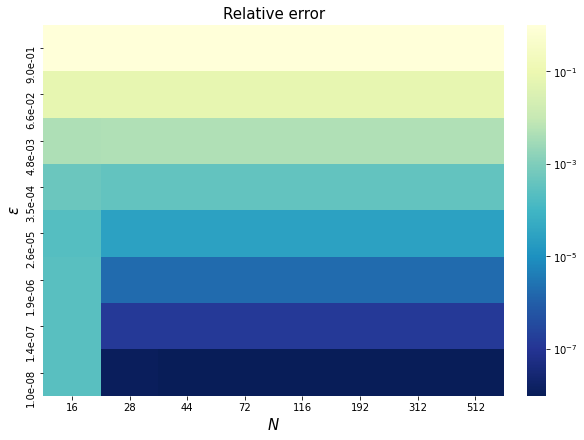

In [6]:
plot_err(α, k, M, N_vec, ε_vec, "qpax", "full", 15)

## Relative error for PQR

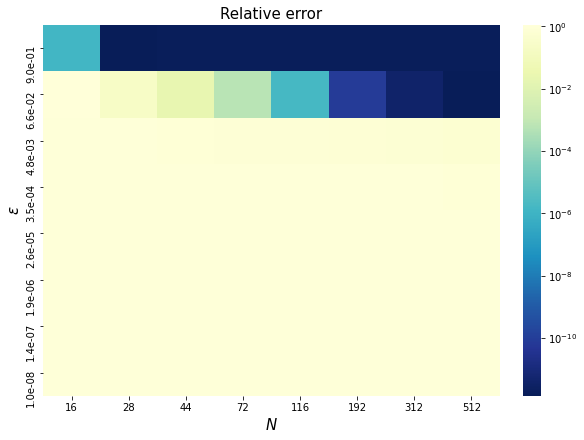

In [7]:
plot_err(α, k, M, N_vec, ε_vec, "pqr", "full", 15)